# A One-Stage Sabermetrics Bayesian Model of Baseball Predictions

## AM207 Final Project
## Author: Thomas Leu

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

import string
import json

## Introduction

An [article](http://www.jds-online.com/v2-1) published in the Journal of Data Science in January 2001 attempts to 
build a Bayesian model for predicting baseball winners by comparing the winning percentage, batting average, and ERA 
(earned run average) of the opposing teams. These statistical measurements were widely used to compare teams and 
players until [Sabermetrics](http://sabr.org/sabermetrics/the-basics), an analysis of baseball statistics championed
by Bill James and popularized in the book [Moneyball](https://en.wikipedia.org/wiki/Moneyball), began to replace these
traditional ranking systems. 

The following notebook attempts to recreate the statistical models built in Yang and Swartz's paper using OBP (on base 
percentage), 

$$
\Theta = \{r_{\alpha}, r_{\beta}, r_{\gamma},\delta\}
$$

$$
\theta_s = \{r_{\alpha_s}, r_{\beta_s}, r_{\gamma_s}, \delta_s\}
$$

$$
D = \{\alpha_s, \beta_s, \gamma_s|s=1,...,T\}
$$

$$
P(\Theta|X,D) = P(X,D|\Theta)P(\Theta) 
$$

$$ 
= \Pi_s (\frac{\lambda_s \delta}{1 + \lambda_s \delta})^{X_s} (\frac{1}{1+\lambda_s \delta})^{(1-X_t)}P(\theta_s)
$$

$$
\propto \Sigma_s [X_s ln(\frac{\lambda_s \delta}{1 + \lambda_s \delta}) 
                 + (1-X_s)ln(\frac{1}{1+\lambda_s \delta})]
$$

In [3]:
###-----------------###
### POSTSEASON DATA ###
###-----------------###

## NOTE:
## This cell and the following are my attempts to use only postseason data when generating samples. I abandoned this 
## idea for reasons described in my paper. They are left here only as reference for how this was performed, and I
## cannot guarantee that they will function correctly as they have not been tested with the latest changes to the
## notebook.

# # load 2014 postseason data
# with open('data/2014_postseason.json', 'r') as infile:
#     postseason_2014_str = infile.read()
#     postseason_2014 = json.loads(postseason_2014_str)
    
# num_games = len(postseason_2014['games'])
# original_data = np.empty((num_games,3))
# sabr_data = np.empty((num_games,3))
# home_wins = np.empty(num_games)


# pitchers = postseason_2014['pitchers']
# teams = postseason_2014['teams']

# def original_game_data(game):
#     home = game['home']; away = game['away']
#     era_ratio = pitchers[away['starter']]['era'] / pitchers[home['starter']]['era']
#     batavg_ratio = teams[home['team']]['BAT_AVG'] / teams[away['team']]['BAT_AVG']
#     win_ratio = teams[home['team']]['WIN_PCT'] / teams[away['team']]['WIN_PCT']
#     return np.array([era_ratio, batavg_ratio, win_ratio]), game['x']
    
# def sabr_game_data(game):
#     home = game['home']; away = game['away']
#     fip_ratio = pitchers[away['starter']]['fip'] / pitchers[home['starter']]['fip']
#     ops_ratio = teams[home['team']]['OPS'] / teams[away['team']]['OPS']
#     win_ratio = teams[home['team']]['WIN_PCT'] / teams[away['team']]['WIN_PCT']
#     return np.array([fip_ratio, ops_ratio, win_ratio]), game['x']

# # build numpy data objects
# for i in xrange(num_games):
#     game = postseason_2014['games'][i]
#     original_data[i], home_wins[i] = original_game_data(game)
#     sabr_data[i], _ = sabr_game_data(game)

In [4]:
# samples = np.zeros((num_samples+1,4)) # add one for initial sample
# samples[0] = np.random.uniform(high=upper_bound,size=4)


# # original paper sampling
# for i in xrange(1, num_samples+1):
#     sample = samples[i-1].copy()
#     sample[0] = draw_r(home_wins, original_data, sample[:-1], sample[-1], 0, accepted) # r_alpha_s
#     sample[1] = draw_r(home_wins, original_data, sample[:-1], sample[-1], 1, accepted) # r_beta_s
#     sample[2] = draw_r(home_wins, original_data, sample[:-1], sample[-1], 2, accepted) # r_gamma_s
#     sample[3] = draw_delta(home_wins, original_data, sample[:-1], sample[-1], accepted)
#     samples[i] = sample
# print "R1 acceptance: {}".format(np.float(accepted[0])/num_samples)
# print "R2 acceptance: {}".format(np.float(accepted[1])/num_samples)
# print "R3 acceptance: {}".format(np.float(accepted[2])/num_samples)
# print "Delta acceptance: {}".format(np.float(accepted[3])/num_samples)
# plt.hist(samples[:,3])    

# samples = np.zeros((num_samples+1,4)) # add one for initial sample
# samples[0] = np.random.uniform(high=upper_bound,size=4)
# accepted = [0,0,0,0]

# for i in xrange(1, num_samples+1):
#     sample = samples[i-1].copy()
#     sample[0] = draw_r(home_wins, sabr_data, sample[:-1], sample[-1], 0, accepted) # r_alpha_s
#     sample[1] = draw_r(home_wins, sabr_data, sample[:-1], sample[-1], 1, accepted) # r_beta_s
#     sample[2] = draw_r(home_wins, sabr_data, sample[:-1], sample[-1], 2, accepted) # r_gamma_s
#     sample[3] = draw_delta(home_wins, sabr_data, sample[:-1], sample[-1], accepted)
#     samples[i] = sample
# print "R1 acceptance: {}".format(np.float(accepted[0])/num_samples)
# print "R2 acceptance: {}".format(np.float(accepted[1])/num_samples)
# print "R3 acceptance: {}".format(np.float(accepted[2])/num_samples)
# print "Delta acceptance: {}".format(np.float(accepted[3])/num_samples)
# plt.subplot(2,2,1).hist(samples[:,0])
# plt.subplot(2,2,2).hist(samples[:,1])
# plt.subplot(2,2,3).hist(samples[:,2])
# plt.subplot(2,2,4).hist(samples[:,3])

In [5]:
# load 2014 regular season data if it is not already loaded
try: 
    regular_season_2014
except NameError:
    with open('data/combinedMLBData.json', 'r') as infile:
        regular_season_2014_str = infile.read()
        regular_season_2014 = json.loads(regular_season_2014_str)

# An ERA or FIP of 0 is most likely the result of the MLB team pulling up a minor league pitcher. These 
# games are ignored because adding a pseudo-count of 0.1 (a very good ERA or FIP) would give a huge
# advantage to that team, even though starting a young pitcher would most likely be a disadvantage
# for the team. 
for game in regular_season_2014:
    home = game['home']; away = game['away']
    if away['era'] == 0 or home['era'] == 0 or away['fip'] == 0 or home['fip'] == 0:
        regular_season_2014.remove(game)

# number of games in the sample
num_games = len(regular_season_2014)

def original_reg_game_data(game):
    # Returns an array with the values of alpha_s, beta_s, and gamma_s and x_s
    # using the statistics in the original paper
    home = game['home']; away = game['away']
    era_ratio = away['era'] / home['era']
    # pseudo-counts are added for values of 0 
    ba_ratio = np.max(home['avg'], 0.1) / np.max(away['avg'], 0.1)
    win_ratio = np.max(home['win_pct'], 0.1) / np.max(away['win_pct'], 0.1)
    return np.array([win_ratio, ba_ratio, era_ratio]), game['x']

def sabr_reg_game_data(game):
    # Returns an array with the values of alpha_s, beta_s, and gamma_s and x_s
    # using the sabermetrics statistics
    home = game['home']; away = game['away']
    fip_ratio = away['fip'] / np.float(home['fip'])
    # pseudo-counts are added for values of 0 
    ops_ratio = np.max(home['ops'], 0.1) / np.max(away['ops'], 0.1) 
    win_ratio = np.max(home['win_pct'], 0.1) / np.max(away['win_pct'], 0.1)
    return np.array([win_ratio, ops_ratio, fip_ratio]), game['x']

# create separate arrays of (alpha_s, beta_s, gamma_s) and x_s
original_reg_data = np.empty((num_games,3))
sabr_reg_data = np.empty((num_games,3))
reg_home_wins = np.empty(num_games)
for i in xrange(num_games):
    game = regular_season_2014[i]
    original_reg_data[i], reg_home_wins[i] = original_reg_game_data(game)
    sabr_reg_data[i], _ = sabr_reg_game_data(game)


In [12]:
def lambda_delta(ratios, weights, home_adv):
    return np.prod(ratios ** weights, 1) * home_adv

def model_1_log_likelihood(home_wins, ratios, weights, home_adv):
    '''Calculates the likelihood of the given parameters and data within
    log space
    
    --Keywords--
    :home_wins: A binary array with (x_s = 1) => home win in game s
    :ratios: An size (m,n) float array with the ratios of the home and away teams stats
    :weights: A size (1,n) float array with the weights for each statistical ratio
    :home_adv: A constant measuring home field advantage'''
    ld = lambda_delta(ratios, weights, home_adv)
    return np.sum(home_wins*np.log(ld/(1+ld))+(1-home_wins)*np.log(1/(1+ld)))

# global variables for drawing samples
burnin = 10000
num_samples = 100000
lower_bound = 0.
upper_bound = 10.

def bounds(current, step_size):
    low = max(lower_bound, current-step_size)
    high = min(upper_bound, current+step_size)
    return low, high

def draw_r(home_wins, ratios, weights, home_adv, index, accepted, step_size):
    # initial likelihood
    weight = weights[index]
    loglik = model_1_log_likelihood(home_wins, ratios, weights, home_adv)
    
    # new likelihood
    low, high = bounds(weight, step_size) 
    weights_star = weights.copy()
    weight_star = np.random.uniform(low=low, high=high)
    weights_star[index] = weight_star
    loglik_star = model_1_log_likelihood(home_wins, ratios, weights_star, home_adv)

    # determine acceptance
    if loglik_star - loglik >= np.log(np.random.uniform()):
        accepted[index] += 1
        return weight_star
    return weight

def draw_delta(home_wins, ratios, weights, delta, accepted, step_size):
    low, high = bounds(delta, step_size)
    delta_star = np.random.uniform(low=low, high=high)
    loglik = model_1_log_likelihood(home_wins, ratios, weights, delta)
    loglik_star = model_1_log_likelihood(home_wins, ratios, weights, delta_star)
    
    if loglik_star - loglik >= np.log(np.random.uniform()):
        accepted[-1] += 1
        return delta_star
    return delta

R1 acceptance: 0.50867
R2 acceptance: 0.66528
R3 acceptance: 0.26965
Delta acceptance: 0.36597


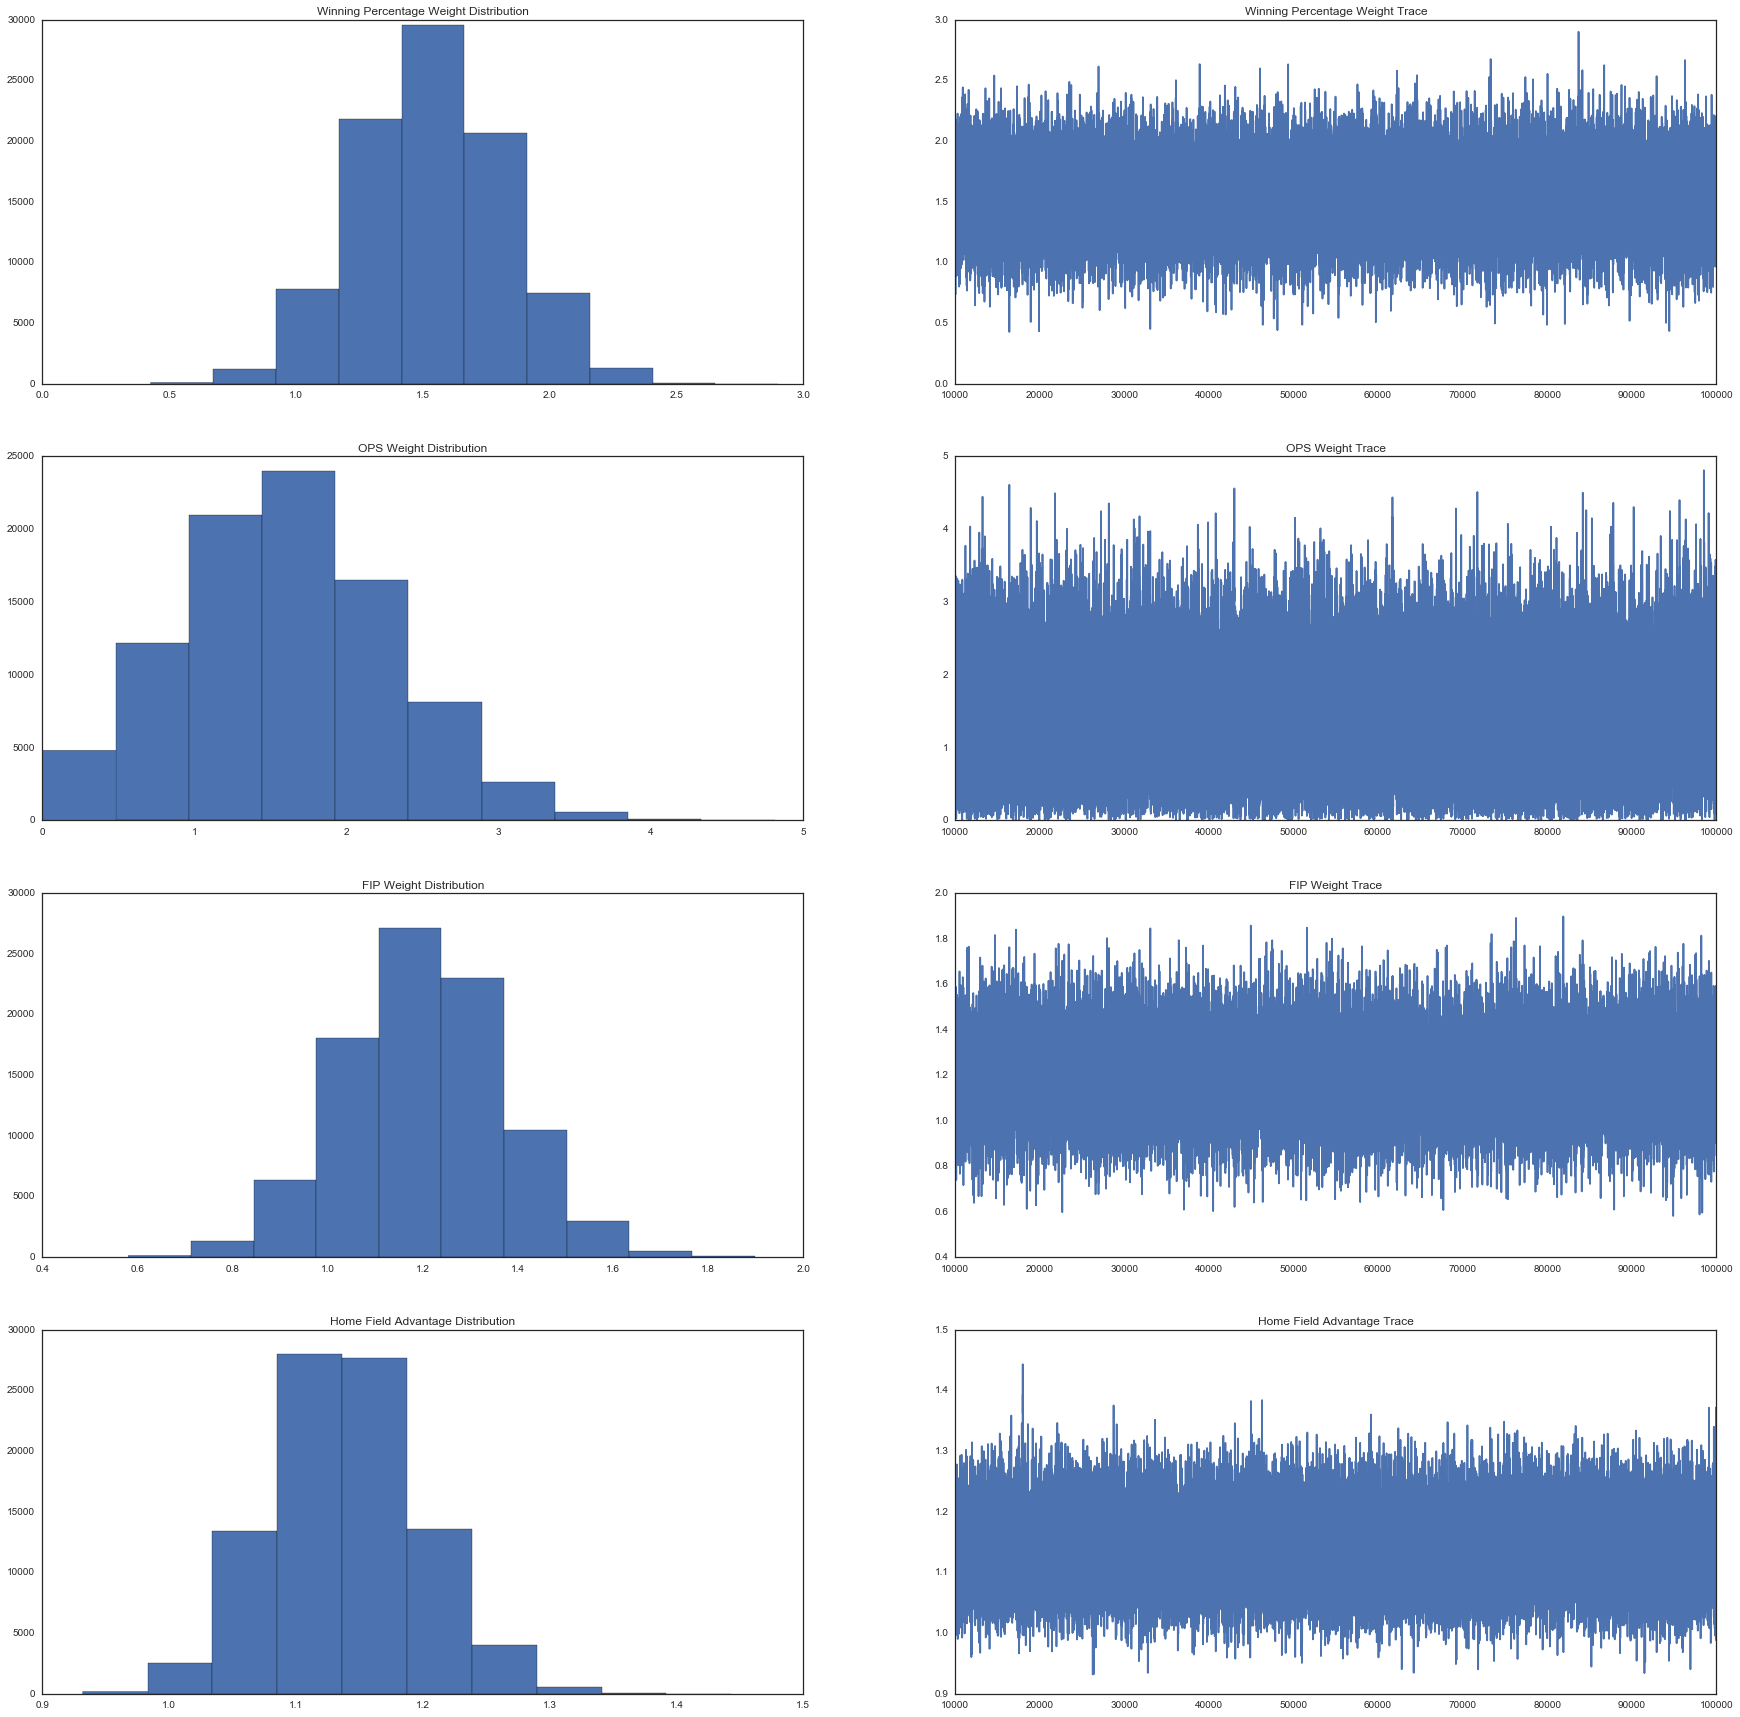

In [13]:
r_alpha_step_size = 0.8
r_beta_step_size = 1.6
r_gamma_step_size = 1.
delta_step_size = 0.25

sabr_samples = np.zeros((num_samples+1,4))
sabr_samples[0] = np.random.uniform(low=lower_bound, high=upper_bound, size=4)
accepted = [0,0,0,0]

for i in xrange(1, num_samples+1):
    sample = sabr_samples[i-1].copy()
    sample[0] = draw_r(reg_home_wins, sabr_reg_data, sample[:-1], sample[-1], 0, accepted, r_alpha_step_size)
    sample[1] = draw_r(reg_home_wins, sabr_reg_data, sample[:-1], sample[-1], 1, accepted, r_beta_step_size)
    sample[2] = draw_r(reg_home_wins, sabr_reg_data, sample[:-1], sample[-1], 2, accepted, r_gamma_step_size)
    sample[3] = draw_delta(reg_home_wins, sabr_reg_data, sample[:-1], sample[-1], accepted, delta_step_size)
    sabr_samples[i] = sample
    
print "R1 acceptance: {}".format(np.float(accepted[0])/num_samples)
print "R2 acceptance: {}".format(np.float(accepted[1])/num_samples)
print "R3 acceptance: {}".format(np.float(accepted[2])/num_samples)
print "Delta acceptance: {}".format(np.float(accepted[3])/num_samples)
plt.figure(figsize=(30,30))
plt.subplot(4,2,1).set_title('Winning Percentage Weight Distribution')
plt.subplot(4,2,1).hist(sabr_samples[:,0][burnin:])
plt.subplot(4,2,2).set_title('Winning Percentage Weight Trace')
plt.subplot(4,2,2).plot(xrange(burnin, num_samples+1), sabr_samples[:,0][burnin:])
plt.subplot(4,2,3).set_title('OPS Weight Distribution')
plt.subplot(4,2,3).hist(sabr_samples[:,1][burnin:])
plt.subplot(4,2,4).set_title('OPS Weight Trace')
plt.subplot(4,2,4).plot(xrange(burnin, num_samples+1), sabr_samples[:,1][burnin:])
plt.subplot(4,2,5).set_title('FIP Weight Distribution')
plt.subplot(4,2,5).hist(sabr_samples[:,2][burnin:])
plt.subplot(4,2,6).set_title('FIP Weight Trace')
plt.subplot(4,2,6).plot(xrange(burnin, num_samples+1), sabr_samples[:,2][burnin:])
plt.subplot(4,2,7).set_title('Home Field Advantage Distribution')
plt.subplot(4,2,7).hist(sabr_samples[:,3][burnin:])
plt.subplot(4,2,8).set_title('Home Field Advantage Trace')
_ = plt.subplot(4,2,8).plot(xrange(burnin, num_samples+1), sabr_samples[:,3][burnin:])

R1 acceptance: 0.61315
R2 acceptance: 0.57343
R3 acceptance: 0.17212
Delta acceptance: 0.31315


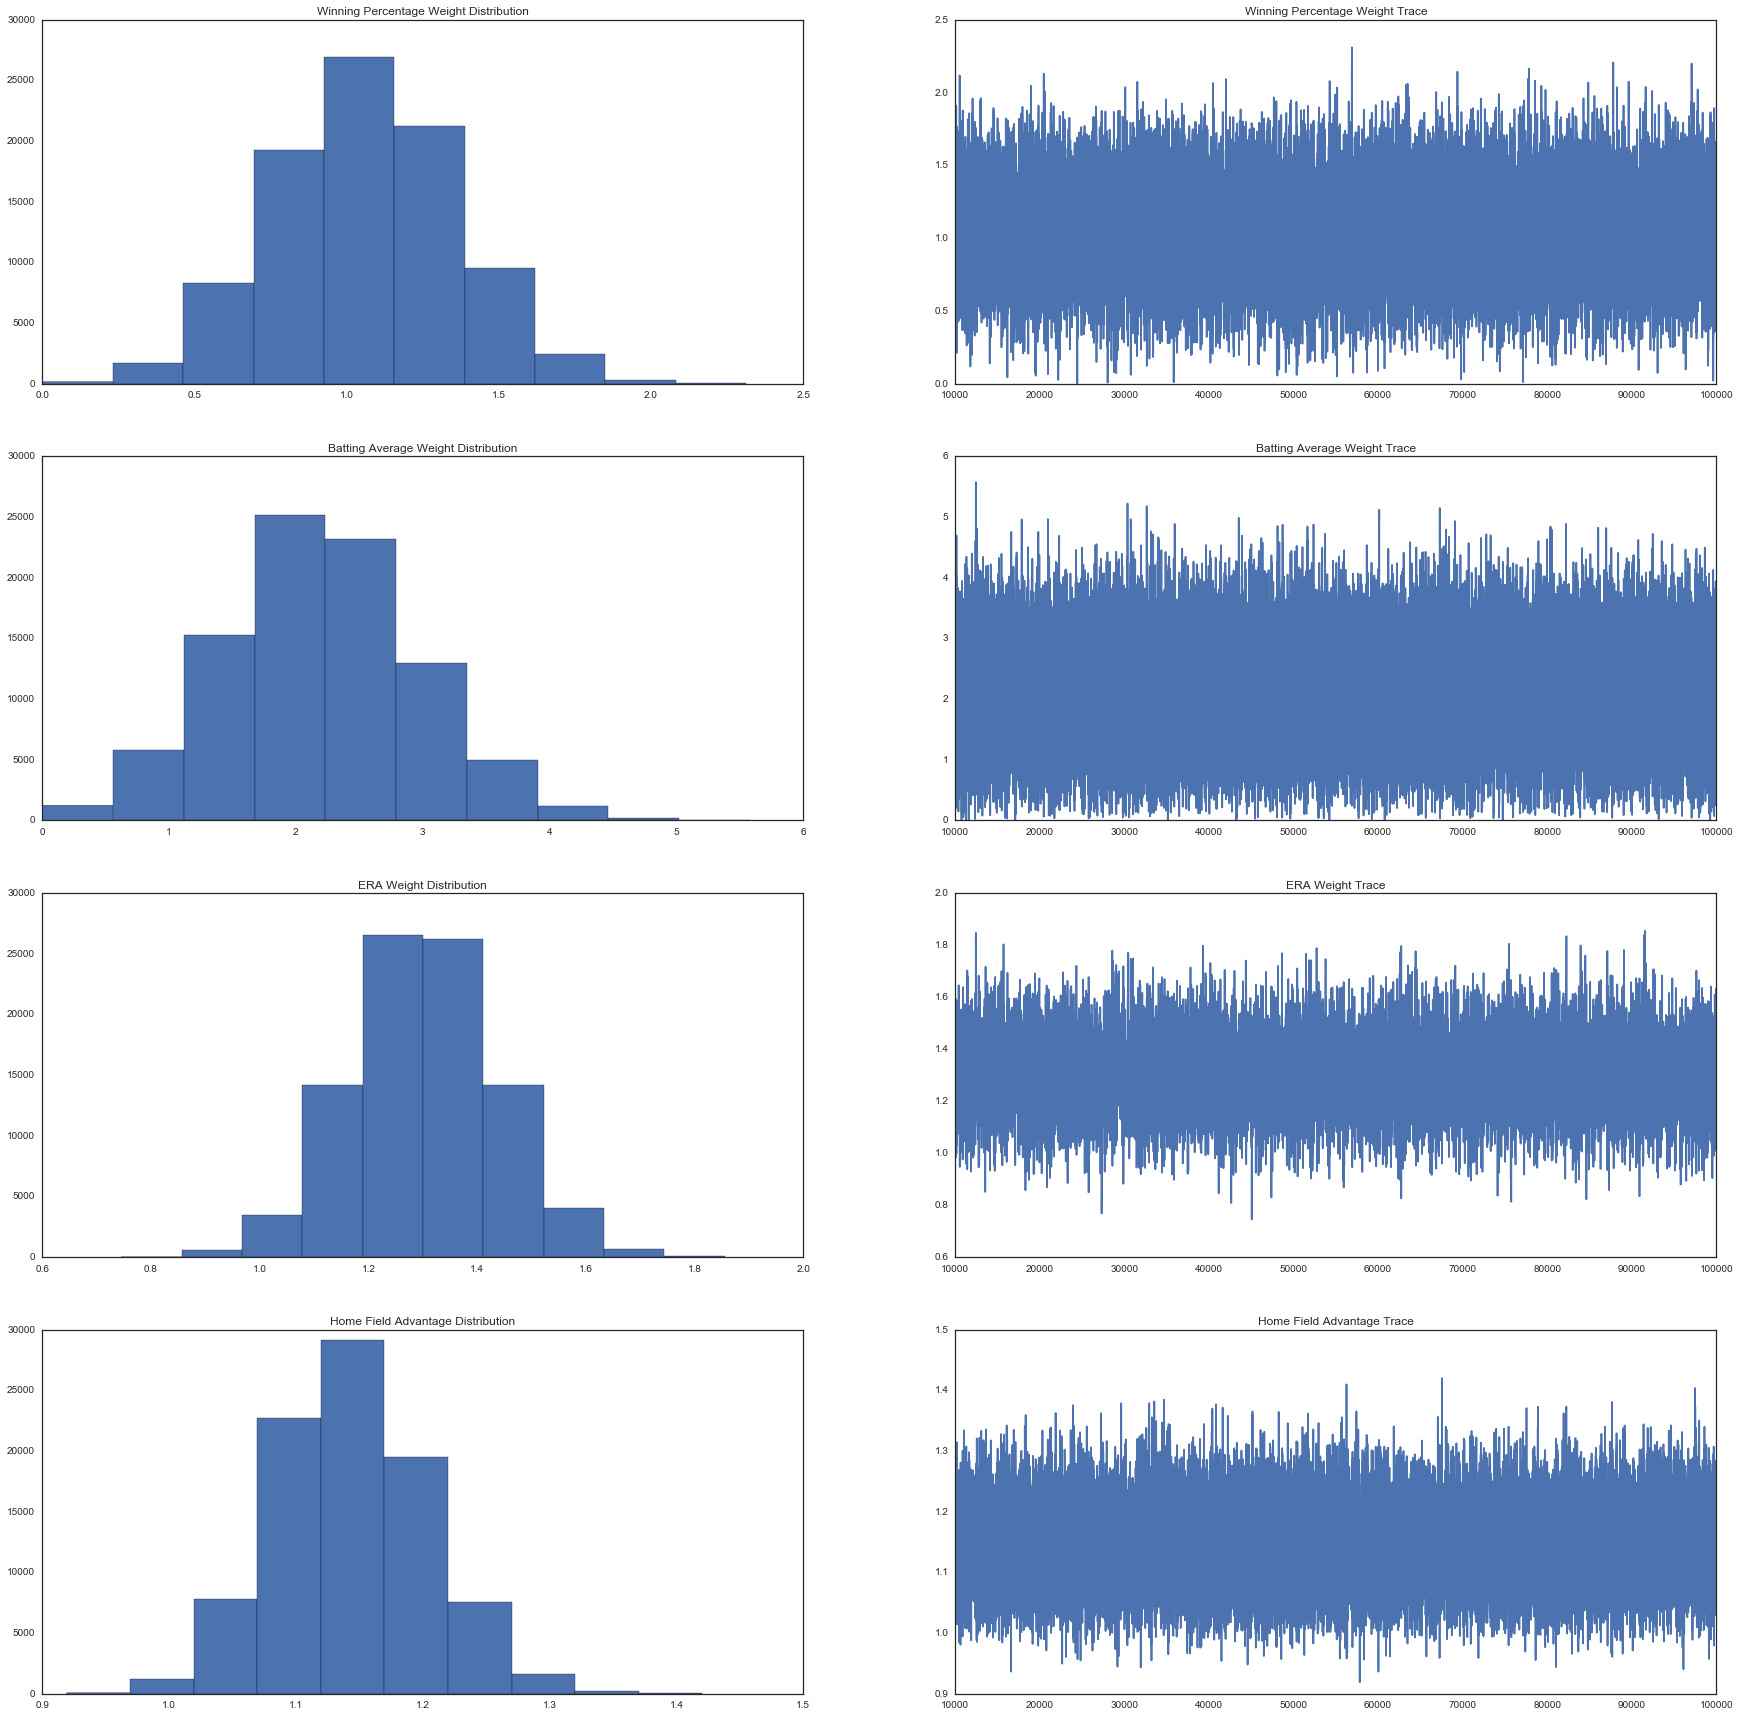

In [14]:
# variables for drawing samples
r_alpha_step_size = .6
r_beta_step_size = 2.
r_gamma_step_size = 1.2
delta_step_size = .3

###--------------###
### DRAW SAMPLES ###
###--------------###

orig_samples = np.zeros((num_samples+1,4))
orig_samples[0] = np.random.uniform(low=lower_bound, high=upper_bound, size=4)
accepted = [0,0,0,0]

for i in xrange(1, num_samples+1):
    sample = orig_samples[i-1].copy()
    sample[0] = draw_r(reg_home_wins, original_reg_data, sample[:-1], sample[-1], 0, accepted, r_alpha_step_size)
    sample[1] = draw_r(reg_home_wins, original_reg_data, sample[:-1], sample[-1], 1, accepted, r_beta_step_size)
    sample[2] = draw_r(reg_home_wins, original_reg_data, sample[:-1], sample[-1], 2, accepted, r_gamma_step_size)
    sample[3] = draw_delta(reg_home_wins, original_reg_data, sample[:-1], sample[-1], accepted, delta_step_size)
    orig_samples[i] = sample
    
print "R1 acceptance: {}".format(np.float(accepted[0])/num_samples)
print "R2 acceptance: {}".format(np.float(accepted[1])/num_samples)
print "R3 acceptance: {}".format(np.float(accepted[2])/num_samples)
print "Delta acceptance: {}".format(np.float(accepted[3])/num_samples)
plt.figure(figsize=(30,30))
plt.subplot(4,2,1).set_title('Winning Percentage Weight Distribution')
plt.subplot(4,2,1).hist(orig_samples[:,0][burnin:])
plt.subplot(4,2,2).set_title('Winning Percentage Weight Trace')
plt.subplot(4,2,2).plot(xrange(burnin, num_samples+1), orig_samples[:,0][burnin:])
plt.subplot(4,2,3).set_title('Batting Average Weight Distribution')
plt.subplot(4,2,3).hist(orig_samples[:,1][burnin:])
plt.subplot(4,2,4).set_title('Batting Average Weight Trace')
plt.subplot(4,2,4).plot(xrange(burnin, num_samples+1), orig_samples[:,1][burnin:])
plt.subplot(4,2,5).set_title('ERA Weight Distribution')
plt.subplot(4,2,5).hist(orig_samples[:,2][burnin:])
plt.subplot(4,2,6).set_title('ERA Weight Trace')
plt.subplot(4,2,6).plot(xrange(burnin, num_samples+1), orig_samples[:,2][burnin:])
plt.subplot(4,2,7).set_title('Home Field Advantage Distribution')
plt.subplot(4,2,7).hist(orig_samples[:,3][burnin:])
plt.subplot(4,2,8).set_title('Home Field Advantage Trace')
_ = plt.subplot(4,2,8).plot(xrange(burnin, num_samples+1), orig_samples[:,3][burnin:])

In [15]:
# Predictive trials
num_trials = 1000

# Functions for determining probabilities
lam_delt = lambda ratios, weights, delt: np.prod(ratios ** weights) * delt
prob_home = lambda ld: (ld) / (1 + ld)


###------------------------------###
### ORIGINAL RESULTS PREDICTIONS ###
###------------------------------###

# weights
sabr_mean_r_alpha = np.mean(sabr_samples[:,0][burnin:])
sabr_mean_r_beta = np.mean(sabr_samples[:,1][burnin:])
sabr_mean_r_gamma = np.mean(sabr_samples[:,2][burnin:])
sabr_mean_delta = np.mean(sabr_samples[:,3][burnin:])

sabr_weights = np.array([sabr_mean_r_alpha, sabr_mean_r_beta, sabr_mean_r_gamma])
home_adv = sabr_mean_delta

# run trials
sabr_trials = np.zeros(num_trials)
for trial in xrange(len(sabr_trials)):
    correct = 0
    for i in xrange(len(sabr_reg_data)):
        game = sabr_reg_data[i]
        x = reg_home_wins[i]
        ld = lam_delt(game, sabr_weights, home_adv)
        predicted_win = scipy.stats.bernoulli.rvs(prob_home(ld), size=1)
        if predicted_win[0] == int(x):
            correct += 1
    sabr_trials[trial] = correct / np.float(len(sabr_reg_data))

    
###------------------------------###
### ORIGINAL RESULTS PREDICTIONS ###
###------------------------------###

# weights 
orig_mean_r_alpha = np.mean(orig_samples[:,0][burnin:])
orig_mean_r_beta = np.mean(orig_samples[:,1][burnin:])
orig_mean_r_gamma = np.mean(orig_samples[:,2][burnin:])
orig_mean_delta = np.mean(orig_samples[:,3][burnin:])

# run trials
orig_weights = np.array([orig_mean_r_alpha, orig_mean_r_beta, orig_mean_r_gamma])
home_adv = orig_mean_delta
orig_trials = np.zeros(num_trials)
for trial in xrange(len(orig_trials)):
    correct = 0
    for i in xrange(len(original_reg_data)):
        game = original_reg_data[i]
        x = reg_home_wins[i]
        ld = lam_delt(game, orig_weights, home_adv)
        predicted_win = scipy.stats.bernoulli.rvs(prob_home(ld), size=1)
        if predicted_win[0] == int(x):
            correct += 1
    orig_trials[trial] = correct / np.float(len(original_reg_data))

# present results
print "SABERMETRICS RESULTS"
print "-" * 80
print "Statistical Weights:"
print "\tWinning Percentage: {}".format(sabr_mean_r_alpha)
print "\tOPS: {}".format(sabr_mean_r_beta)
print "\tFIP: {}".format(sabr_mean_r_gamma)
print "\tHome Field Advantage: {}".format(sabr_mean_delta)
print "\tCorrect Prediction Rate: {}".format(np.mean(sabr_trials))
    
print "\nORIGINAL STATISTICS RESULTS"
print "-" * 80
print "Statistical Weights:"
print "\tWinning Percentage: {}".format(orig_mean_r_alpha)
print "\tBatting Average: {}".format(orig_mean_r_beta)
print "\tERA: {}".format(orig_mean_r_gamma)
print "\tHome Field Advantage: {}".format(orig_mean_delta)
print "\tCorrect Prediction Rate: {}".format(np.mean(orig_trials))

SABERMETRICS RESULTS
--------------------------------------------------------------------------------
Statistical Weights:
	Winning Percentage: 1.53577750361
	OPS: 1.59579063809
	FIP: 1.20229322616
	Home Field Advantage: 1.13927309216
	Correct Prediction Rate: 0.534746804626

ORIGINAL STATISTICS RESULTS
--------------------------------------------------------------------------------
Statistical Weights:
	Winning Percentage: 1.06045748496
	Batting Average: 2.19575025434
	ERA: 1.30236420406
	Home Field Advantage: 1.14389504363
	Correct Prediction Rate: 0.547932440657
